In [2]:
import os
import sys 
import numpy as np
import matplotlib.pyplot as plt
import sys 
import mdtraj
from nglview import show_ase, show_file, show_mdtraj
import torch

import ase
from ase import Atoms
from ase.constraints import FixBondLengths
from ase.calculators.tip3p import TIP3P, rOH, angleHOH
from ase.md import Langevin
import ase.units as units
from ase.io.trajectory import Trajectory
import numpy as np


# Set up water box at 20 deg C density
x = angleHOH * np.pi / 180 / 2
pos = [[0, 0, 0],
       [0, rOH * np.cos(x), rOH * np.sin(x)],
       [0, rOH * np.cos(x), -rOH * np.sin(x)]]
atoms = Atoms('OH2', positions=pos)

atoms.rotate((0.75, 0.5, 0.5), (0, 0, 1))

vol = ((18.01528 / 6.022140857e23) / (0.997 / 1e24))**(1 / 3.)
atoms.set_cell((vol, vol, vol))
atoms.center()

size = 4

atoms = atoms.repeat((4, 4, 4))
atoms.set_pbc(True)

In [3]:
show_ase(atoms)

NGLWidget()

In [4]:
from torchmd.system import System
device = 3

atoms = ase.io.read("../data/water_init_64.xyz")

system = System(atoms, device=device)
system.set_temperature(298.0)


In [6]:
show_ase(atoms)

NGLWidget()

In [9]:
# Initialize topologies 
bond_top = [ [3 * i, 3 * i + j + 1] for i in range(size**3) for j in range(2)  ]
bond_top = torch.LongTensor(bond_top)

angle_top = [[ 3* i +1, 3 * i, 3 * i + 2] for i in range(size ** 3) ]
angle_top = torch.LongTensor(angle_top)

hh_tuple = [[ 3* i +1, 3 * i + 2] for i in range(size ** 3) ]
hh_tuple = torch.LongTensor(hh_tuple)

In [11]:
system.get_temperature()

300.9603782312883

In [12]:
from torchmd.system import AnglePotentials, BondPotentials, Electrostatics

KCAL_TO_EV = 4.3363e-2

k_bond =  450 * KCAL_TO_EV 
k_angle = 55 * KCAL_TO_EV 

bondenergy = BondPotentials(system, bond_top, k_bond, rOH)
angleenergy = AnglePotentials(system, angle_top, k_angle, angleHOH * np.pi / 180 )

charges = torch.Tensor( [-0.834, 0.417, 0.417] * (size ** 3) )
coulomb = Electrostatics(charges, system.get_cell_len(), device=device,
                                cutoff=6, index_tuple=None, ex_pairs=torch.cat((hh_tuple, bond_top), dim=0))

# get atom type index
o_index = [i * 3 for i in range(size ** 3)]
h_index = [i * 3 + j + 1 for i in range(size ** 3) for j in range(2)]

In [13]:
oo_start = 2.4
oo_end = 5.75
oh_start = 1.5
oh_end = 5.75
hh_start = 1.25
hh_end = 5.75

nbins = 60

data_oo = np.load("../data/water_exp_pccp.npy")
data_oh = np.load("../data/water_exp_jcp_oh.npy")
data_hh = np.load("../data/water_exp_jcp_hh.npy")

count_obs, g_oo_data = get_exp_rdf(data_oo, nbins, (oo_start, oo_end), obs_oo)
count_obs, g_oh_data = get_exp_rdf(data_oh, nbins, (oh_start, oh_end), obs_oh)
count_obs, g_hh_data = get_exp_rdf(data_hh, nbins, (hh_start, hh_end), obs_hh)

NameError: name 'get_exp_rdf' is not defined

In [51]:
from torchmd.system import GNNPotentials,PairPotentials,System, Stack
from torchmd.potentials import ExcludedVolume, LennardJones
from nff.train import get_model

#lj_params = {'epsilon': 0.001, 'sigma': 1.5, 'power': 12}

params = {
    'n_atom_basis': 128,
    'n_filters': 128,
    'n_gaussians': 25,
    'n_convolutions': 2,
    'cutoff': 4.5,
    'trainable_gauss': False
}

epsilon_scale = 1.0
sigma_scale = 1.0

pair_oo = PairPotentials(LennardJones, {'epsilon': epsilon_scale * 0.1521 * KCAL_TO_EV, 'sigma': 3.15 * sigma_scale},
                cell=torch.Tensor(system.get_cell_len()), 
                device=device,
                index_tuple=(o_index, o_index),
                cutoff=6.0,
                ).to(device)

pair_oh = PairPotentials(LennardJones, {'epsilon': epsilon_scale * 0.086 * KCAL_TO_EV, 'sigma': 1.77 * sigma_scale},
                cell=torch.Tensor(system.get_cell_len()), 
                device=device,
                index_tuple=(o_index, h_index),
                ex_pairs=bond_top,
                cutoff=6.0,
                ).to(device)

pair_hh = PairPotentials(LennardJones, {'epsilon': epsilon_scale * 0.046 * KCAL_TO_EV, 'sigma': 0.4 * sigma_scale},
                cell=torch.Tensor(system.get_cell_len()), 
                device=device,
                index_tuple=(h_index, h_index),
                ex_pairs=hh_tuple,
                cutoff=6.0,
                ).to(device)

model = get_model(params)
GNN = GNNPotentials(model, system.get_batch(), system.get_cell_len(), cutoff=5.5, device=system.device)
model = Stack({'gnn': GNN, 
               'pair_oo': pair_oo,
               'pair_oh': pair_oh, 
               'pair_hh': pair_hh, 
               'angle': angleenergy, 
               'bond': bondenergy,
               'coulomb': coulomb
                })

In [52]:
# Initialize Observables
from torchmd.observable import rdf, vacf

# Set up observable 
obs_oo = rdf(system, nbins=nbins, r_range=(oo_start, oo_end), index_tuple=(o_index, o_index))
obs_oh = rdf(system, nbins=nbins, r_range=(oh_start, oh_end), index_tuple=(o_index, h_index))
obs_hh = rdf(system, nbins=nbins, r_range=(hh_start, hh_end), index_tuple=(h_index, h_index))
#vacf_obs = vacf(system, t_range=10)

In [53]:
from torchmd.md import NoseHooverChain 
diffeq =NoseHooverChain(model, 
            system,
            Q=50.0, 
            T=298.0 * units.kB,
            num_chains=5, 
            adjoint=True).to(device)

In [54]:
from scripts.gnn_rdf_aa import get_exp_rdf, JS_rdf, MSE_rdf, plot_all

In [55]:
from torchmd.md import Simulations

#system = System(atoms, device=device)



In [61]:


# warm up training 

def warmup(system, diffeq):

    print("Warming up ")    
     
    sim = Simulations(system, diffeq, wrap=True)

    v_t, q_t, pv_t = sim.simulate(steps=200, frequency=25, dt=0.5 *units.fs)
    optimizer = torch.optim.Adam(list(diffeq.parameters() ), lr=0.0005)
    
    for epoch in range(15):

        for frames in diffeq.traj:

            q = torch.Tensor(frames[1]).to(device)
            q.requires_grad = True
            # u = diffeq.model.models['gnn'](q)

            u = diffeq.model.models['gnn'](q)

            f = compute_grad(q, u)
            loss = f.pow(2).mean()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            print(f.abs().mean().item())
        

In [62]:
warmup(system, diffeq)

Warming up 
0.006643493194133043
0.05728631466627121
0.0216178260743618
0.030888117849826813
0.036457907408475876
0.028588971123099327
0.02024090848863125
0.01920495741069317
0.018341312184929848
0.016408246010541916
0.01658564992249012
0.016270814463496208
0.01693851314485073
0.01654892787337303
0.013245594687759876
0.011780080385506153
0.012205617502331734
0.01068462897092104
0.00953736249357462
0.008997514843940735
0.009388325735926628
0.009674325585365295
0.009336486458778381
0.009242755360901356
0.00970968883484602
0.010713860392570496
0.01003132201731205
0.008411956019699574
0.006942449137568474
0.006610334850847721
0.0069119432009756565
0.00719725526869297
0.009085134603083134
0.008070801384747028
0.007169958669692278
0.006879357621073723
0.006663136649876833
0.006628004834055901
0.006581941153854132
0.005604349076747894
0.00701393187046051
0.007094947155565023
0.0061759850941598415
0.005572421941906214
0.0048711467534303665
0.005696878302842379
0.0061748698353767395
0.006330672

In [59]:
from nff.utils import compute_grad

q = torch.Tensor(frames[1]).to(device)
q.requires_grad = True
u = diffeq.model.models['gnn'](q)

#u = diffeq.model(q)

f= compute_grad(q, u)

In [60]:
f.abs().mean()

tensor(0.0060, device='cuda:3', grad_fn=<MeanBackward0>)

In [39]:
f.abs().mean()

tensor(0.2421, device='cuda:3', grad_fn=<MeanBackward0>)

In [138]:
optimizer = torch.optim.Adam(list(diffeq.parameters() ), lr=0.0005)

In [ ]:
q_t[0]

In [149]:
0.0076 / KCAL_TO_EV

0.17526462652491756

25.193267822265625 6.9499664306640625 0.7889557480812073 32.93218994140625


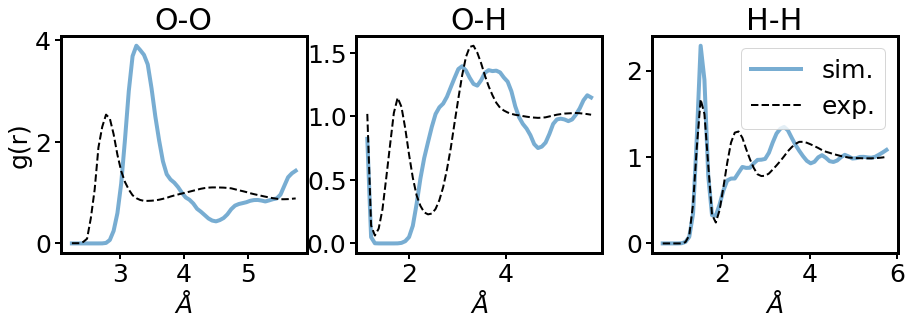

25.128787994384766 7.386711120605469 0.7645952701568604 33.280094146728516


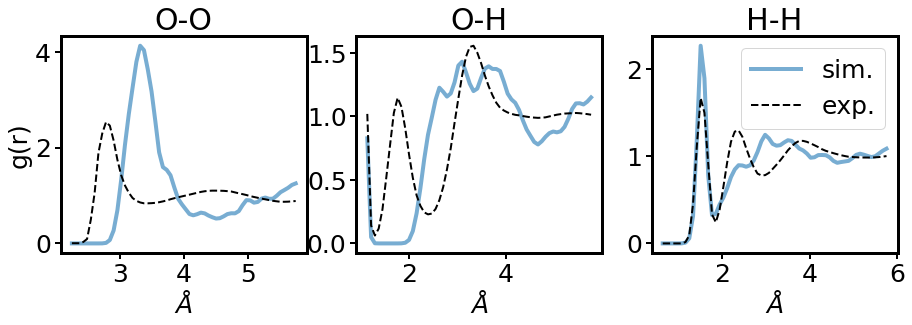

24.865802764892578 7.005556106567383 0.725894570350647 32.597251892089844


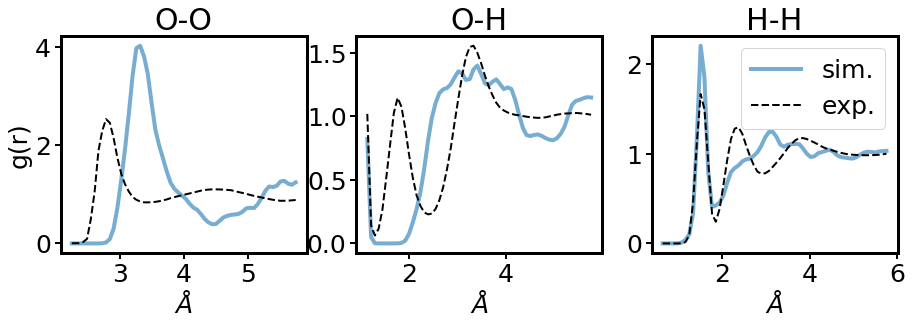

23.586854934692383 6.977416038513184 0.8810081481933594 31.44527816772461


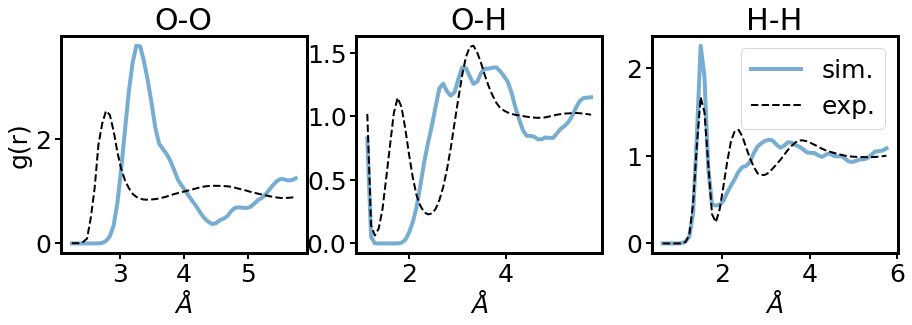

22.575841903686523 6.4847092628479 0.9187382459640503 29.97928810119629


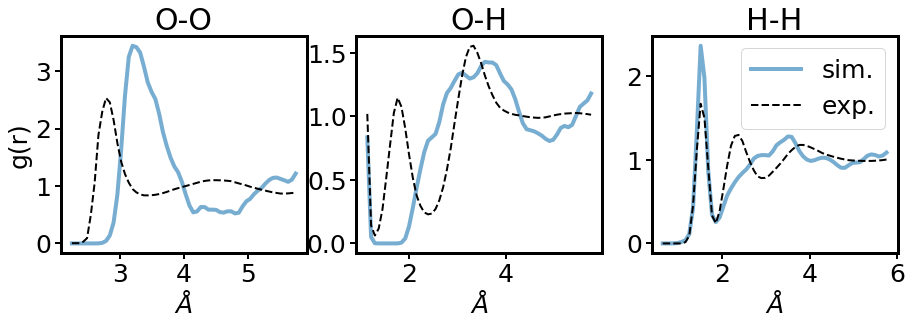

20.672046661376953 5.978464126586914 0.9409357905387878 27.591445922851562


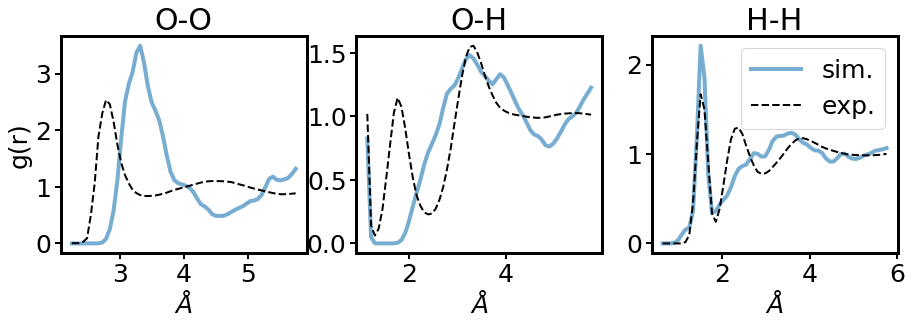

20.2345027923584 6.268266201019287 0.9283082485198975 27.43107795715332


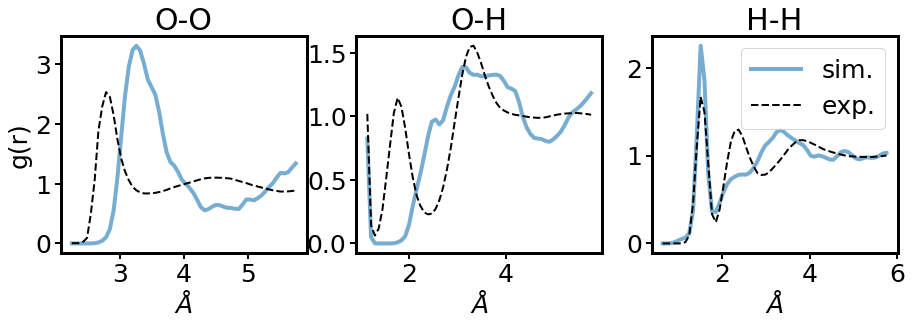

18.72553062438965 6.412437915802002 0.8537369966506958 25.9917049407959


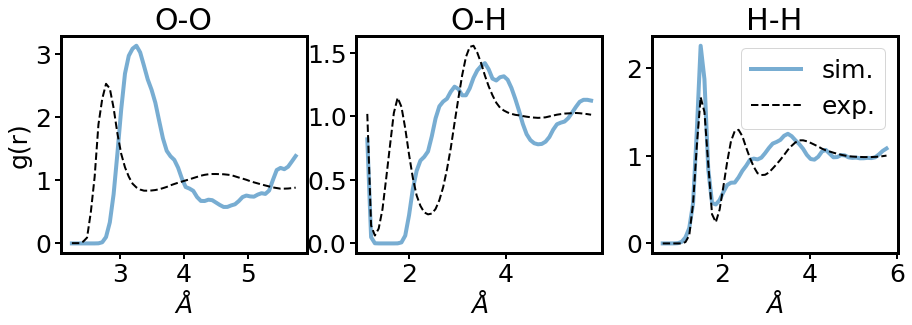

15.254462242126465 6.0584893226623535 1.0493760108947754 22.362327575683594


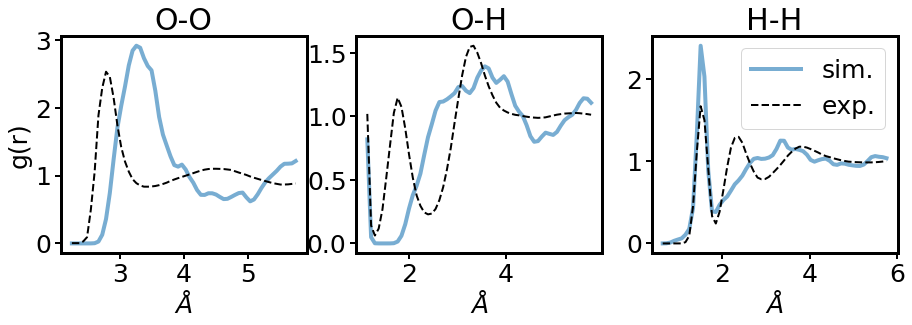

12.778221130371094 6.789459705352783 0.9495718479156494 20.51725196838379


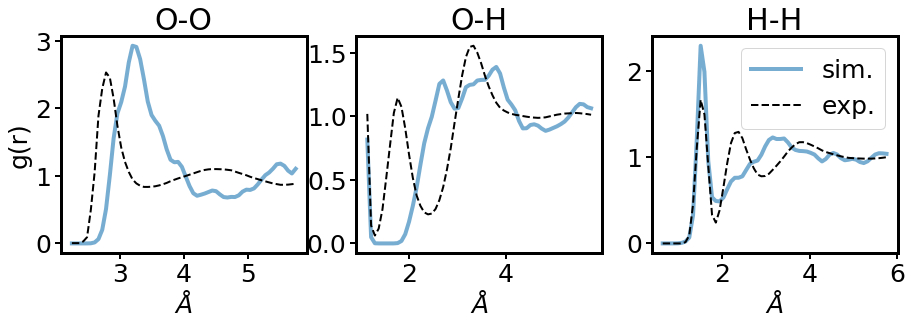

9.812408447265625 5.742957592010498 0.9458751678466797 16.50124168395996


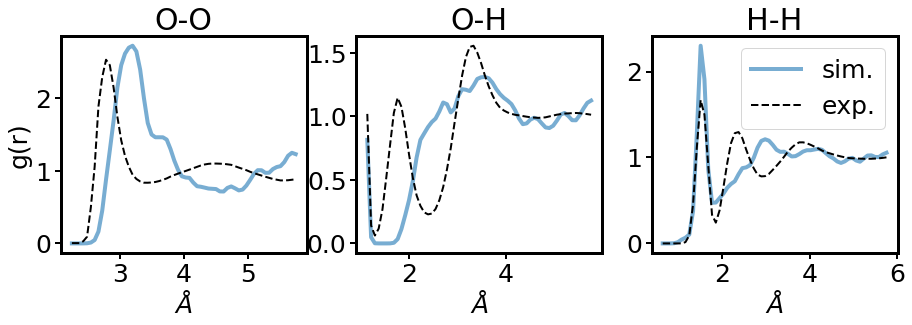

6.550994396209717 5.3887858390808105 1.026747226715088 12.966527938842773


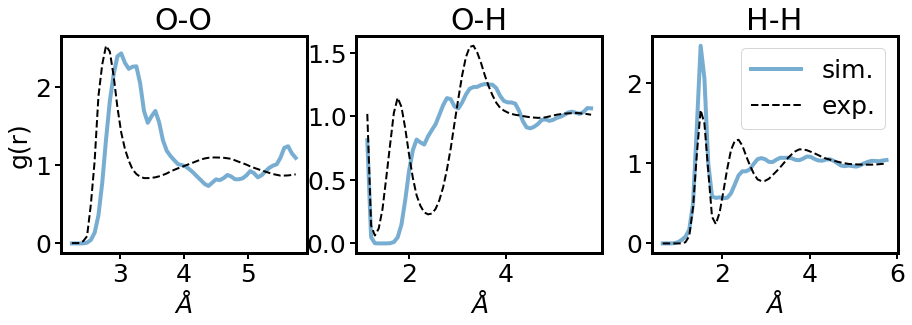

In [140]:
#loss_log = []

#v_t, q_t, pv_t = sim.simulate(steps=2000, frequency=100, dt=0.5 *units.fs)
for epoch in range(12):
    # Set up simulations 
    # Simulate 
    v_t, q_t, pv_t = sim.simulate(steps=100, frequency=100, dt=0.5 *units.fs)
    _, bins, g_oo =  obs_oo(q_t[::5])
    _, bins, g_oh =  obs_oh(q_t[::5])
    _, bins, g_hh =  obs_hh(q_t[::5])
    
    loss_oo = JS_rdf(g_oo, g_oo_data) + MSE_rdf(g_oo, g_oo_data, 0.1)
    loss_oh = JS_rdf(g_oh, g_oh_data) + MSE_rdf(g_oh, g_oh_data, 0.1)
    loss_hh = JS_rdf(g_hh, g_hh_data) + MSE_rdf(g_hh, g_hh_data, 0.1)
    
    loss = loss_oo + loss_oh + loss_hh 

    print(loss_oo.item(), loss_oh.item(), loss_hh.item(), loss.item())
    loss.backward()
    
    optimizer.step()
    optimizer.zero_grad()

    plot_all(g_oo, g_oo_data, (oo_start, oo_end),
             g_oh, g_oh_data, (oh_start, oh_end),
             g_hh, g_hh_data, (hh_start, hh_end),
             nbins, 
             'metadta/', fname="test_{}".format(epoch))
    
    loss_log.append([loss_oo.item(), loss_oh.item(), loss_hh.item()])

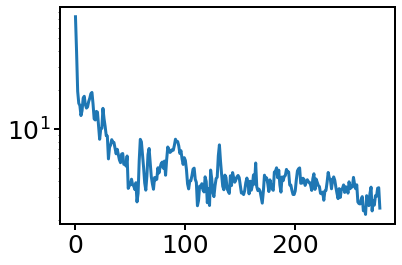

In [69]:
plt.plot(np.array(loss_log)[:, 0])
plt.yscale("log")

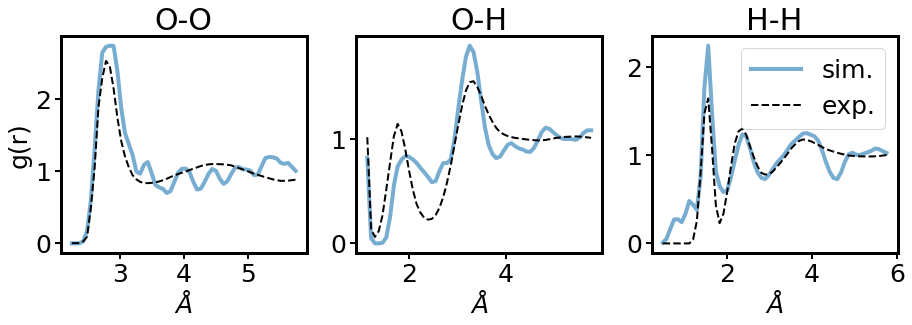

In [144]:
plot_all(g_oo, g_oo_data, (oo_start, oo_end),
         g_oh, g_oh_data, (oh_start, oh_end),
         g_hh, g_hh_data, (hh_start, hh_end),
         nbins, 
         'metadta/', fname=epoch)

In [181]:
from utils import to_mdtraj, display_traj

view = display_traj(system, diffeq.traj)

view.representations = [
    {"type": "spacefill", "params": {
    }}]

In [182]:
view

NGLWidget(max_frame=131)

In [190]:
view.shape.add_arrow([0,0,0], [0,10,10], [0, 0, 0], 1)

In [155]:
system.set_positions(q_t[-1].detach().cpu().numpy())

In [156]:
import ase
ase.io.write("../data/water_init_64.xyz", system)

In [157]:
atoms = ase.io.read("../data/water_init_64.xyz")

In [ ]:
def plot_all(g_oo, g_oo_data, oo_range, g_oh, g_oh_data, oh_range, g_hh, g_hh_data, hh_range, nbins, path, fname):

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(17,4)

    xnew = np.linspace(oo_range[0], oo_range[1], nbins)
    ax1.set_title('O-O')
    ax1.plot(xnew, g_oo.detach().cpu().numpy() , linewidth=4, alpha=0.6, label='sim.' )
    ax1.plot(xnew, g_oo_data.detach().cpu().numpy(), linewidth=2,linestyle='--', c='black', label='exp.')
    ax1.set_ylabel("g(r)")
    ax1.set_xlabel("$\AA$")

    ax2.set_title("O-H")
    xnew = np.linspace(oh_range[0], oh_range[1], nbins)
    ax2.plot(xnew, g_oh.detach().cpu().numpy() , linewidth=4, alpha=0.6, label='sim.' )
    ax2.plot(xnew, g_oh_data.detach().cpu().numpy(), linewidth=2,linestyle='--', c='black', label='exp.')
    ax2.set_xlabel("$\AA$")

    ax3.set_title('H-H')
    xnew = np.linspace(hh_range[0], hh_range[1], nbins)
    ax3.plot(xnew, g_hh.detach().cpu().numpy() , linewidth=4, alpha=0.6, label='sim.' )
    ax3.plot(xnew, g_hh_data.detach().cpu().numpy(), linewidth=2,linestyle='--', c='black', label='exp.')
    ax3.set_xlabel("$\AA$")
    ax3.legend()

    plt.savefig(path + '/{}.jpg'.format(fname), bbox_inches='tight')
    plt.show()
    plt.close()

In [67]:
# get amorphous Silicon

a_si = ase.io.read("../data/a-Si/a-Si.xyz")

In [71]:
a_si.set_cell([32.78, 32.78, 32.78])

a_si = System(a_si, device=3)



In [116]:
nbins=100
obs = rdf(a_si, nbins=nbins, r_range=(0, 12))

In [117]:
coord = torch.Tensor( a_si.get_positions() )[None, ...].to(3)

In [118]:
_, bins, g = obs(coord)

x_new = np.linspace(0, 12, nbins)

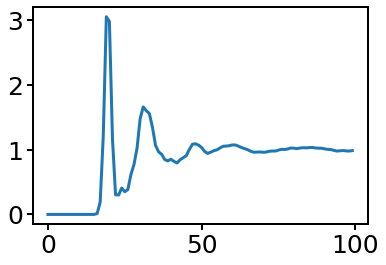

In [119]:
plt.plot(g.detach().cpu().numpy())

In [126]:
data = np.stack( (x_new, g.detach().cpu().numpy() ), axis=-1)

In [127]:
np.savetxt('../data/a-Si/83K_2.287_exp.csv', data)

In [129]:
olddata = np.loadtxt('../data/a-Si/100K_2.293.csv', delimiter=',')

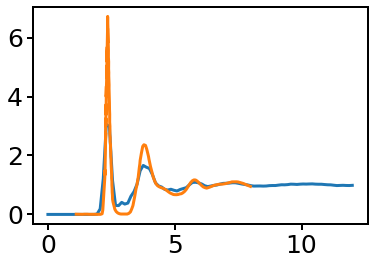

In [134]:
plt.plot(data[:,0], data[:,1])
plt.plot(olddata[:,0], olddata[:,1])

In [133]:
olddata

array([[1.11645330e+00, 7.51153324e-03],
       [1.17879953e+00, 6.57440072e-03],
       [1.24114576e+00, 6.57440072e-03],
       [1.30065807e+00, 7.98009950e-03],
       [1.36867214e+00, 2.31044776e-03],
       [1.43952013e+00, 7.51153324e-03],
       [1.50186635e+00, 7.98009950e-03],
       [1.55783626e+00, 7.33582090e-03],
       [1.62089097e+00, 2.82587065e-03],
       [1.70024072e+00, 2.35730439e-03],
       [1.76258695e+00, 2.82587065e-03],
       [1.82493318e+00, 2.35730439e-03],
       [1.88727941e+00, 1.88873813e-03],
       [1.94962564e+00, 2.82587065e-03],
       [2.02006878e+00, 4.29850746e-03],
       [2.07431809e+00, 2.82587065e-03],
       [2.13666432e+00, 2.20370873e-02],
       [2.16386995e+00, 1.51267662e-01],
       [2.17539456e+00, 3.12079602e-01],
       [2.19050879e+00, 4.77659204e-01],
       [2.19901055e+00, 6.30610945e-01],
       [2.21247167e+00, 7.90962687e-01],
       [2.22168191e+00, 9.51203980e-01],
       [2.23625635e+00, 1.10362189e+00],
       [2.241519